### Data exploration and preprocessing for the [...] dataset

In [ ]:
"""
Load the source dataset and preprocess it

__ imgs
    |
    |__ fold_1
          |__ datasetname_id.png --> images
          |__ ...
    |__ fold_2
          |__ datasetname_id.png
          |__ ...
    |__ fold_3
          |__ datasetname_id.png
          |__ ...
    |__ fold_4
          |__ datasetname_id.png
          |__ ...
    |__ fold_5
          |__ datasetname_id.png
          |__ ...

__ masks
    |
    |__ fold_1
          |__ datasetname_id.png  --> segmentation mask
          |__ ...
    |__ fold_2
          |__ datasetname_id.png
          |__ ...
    |__ fold_3
          |__ datasetname_id.png
          |__ ...
    |__ fold_4
          |__ datasetname_id.png
          |__ ...
    |__ fold_5
          |__ datasetname_id.png
          |__ ...

For segmentation masks --> 0 and 1 (if more than 2 labels --> use SimpleITK to encode integers in images)
"""

In [2]:
# dataset is downloaded from: http://www.andrewjanowczyk.com/use-case-1-nuclei-segmentation/

import numpy as np
import cv2
print("OpenCV version:", cv2.__version__)

from numpy.random import RandomState
import os
import tarfile

from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt

rdm = RandomState(42)

source_file = '/home/rob/Documents/3_projects/bench/NucleiSeg/nuclei.tgz'
target_folder = '/home/rob/Documents/3_projects/bench/NucleiSeg'

n_patches = 30
patch_size = 480

# Check if file exists
if os.path.isfile(source_file):
    print("Unzipping the source file...")
else:
    raise Exception("No nuclei.tgz file found at", source_file)

# Unzip the file
if not os.path.exists(os.path.join(target_folder, 'imgs')):
    tar = tarfile.open(source_file)
    tar.extractall(target_folder)
    tar.close()

    os.mkdir(os.path.join(target_folder, 'imgs'))
    os.mkdir(os.path.join(target_folder, 'masks'))

    for i in range(5):
        os.mkdir(os.path.join(target_folder, 'imgs', 'fold_'+str(i)))
        os.mkdir(os.path.join(target_folder, 'masks', 'fold_'+str(i)))

    # Make the splits (the first idx is related to patients: a patient cannot be in different folds)
    imgs = [f for f in os.listdir(target_folder) if os.path.isfile(os.path.join(target_folder, f)) and 'original' in f]
    masks = [f for f in os.listdir(target_folder) if os.path.isfile(os.path.join(target_folder, f)) and 'mask' in f]

    patients = []
    for img in imgs:
        patients.append(int(img.split('_')[0]))
        
    patient_idx, patient_counts = np.unique(patients, return_counts=True)
    idx = np.array(range(len(patient_idx)))
    rdm.shuffle(idx)

    split_size = len(patient_idx) // 5
    max_coord = 2000 - patch_size

    split = 0 ; n = 0
    for patient_id, patient_count in zip(patient_idx[idx], patient_counts[idx]):
        if split > 4:
            break

        # Extract random patches
        patient_imgs = []
        patient_masks = []
        for img in imgs:
            if str(patient_id) in img:
                patient_imgs.append(img)
        for mask in masks:
            if str(patient_id) in mask:
                patient_masks.append(mask)

        for i in range(n_patches):
            x, y = int(rdm.uniform(low=0, high=max_coord)), int(rdm.uniform(low=0, high=max_coord))
            id = int(rdm.uniform(low=0, high=len(patient_imgs)))
            
            img = patient_imgs[id]
            mask = patient_masks[id]
            img = plt.imread(os.path.join(target_folder, img))
            mask = plt.imread(os.path.join(target_folder, mask))
            patch_img = img[x:x+patch_size, y:y+patch_size, :]
            patch_mask = (mask[x:x+patch_size, y:y+patch_size]*255.).astype(np.uint8)

            cv2.imwrite(os.path.join(target_folder, 'imgs', 'fold_'+str(split), 
                                     patient_imgs[id].split('.')[0]+'_'+str(i)+'.png'), patch_img)
            cv2.imwrite(os.path.join(target_folder, 'masks', 'fold_'+str(split), 
                                     patient_imgs[id].split('.')[0]+'_'+str(i)+'.png'), patch_mask)
        
        n += 1
        if n == split_size:
            split += 1
            n = 0

OpenCV version: 4.10.0
Unzipping the source file...


### Load some examples to explore the data

In [3]:
# Generate the dataset

folds = ['fold_0', 'fold_1', 'fold_2', 'fold_3', 'fold_4']

testing_folds = [folds.pop(0)]
training_folds = folds

training_data = []
for fold in training_folds:
    training_data += [os.path.join(fold, f) for f in os.listdir(os.path.join(target_folder, 'imgs', fold)) 
                      if os.path.isfile(os.path.join(target_folder, 'imgs', fold, f))]

testing_data = []
for fold in testing_folds:
    testing_data += [os.path.join(fold, f) for f in os.listdir(os.path.join(target_folder, 'imgs', fold)) 
                     if os.path.isfile(os.path.join(target_folder, 'imgs', fold, f))]

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as F
from PIL import Image

class DatasetNuclei(Dataset):
    """
    Images are supposed to be RGB
    Masks are supposed to be L (binary grayscale)
    """
    def __init__(self, dataset_path, filenames=[], transforms={'Resize': None, 'RandomCrop': None, 
                                                               'flip': True, 'rot': True, 
                                                               'Normalize': ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))}):
        self.dataset_path = dataset_path
        self.filenames = filenames
        self.transforms = transforms

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.dataset_path, 'imgs', self.filenames[index])).convert('RGB')
        mask = Image.open(os.path.join(self.dataset_path, 'masks', self.filenames[index])).convert('L')

        tf = [transforms.ToTensor()]
        if self.transforms['Resize']:
            tf.append(transforms.Resize(self.transforms['Resize']))
        if self.transforms['Normalize']:
            tf.append(transforms.Normalize(*self.transforms['Normalize']))
        tf = transforms.Compose(
            tf
        )

        img = tf(img)
        mask = tf(mask)

        if self.transforms['RandomCrop']:
            i, j, h, w = transforms.RandomCrop.get_params(img, self.transforms['RandomCrop'])
            img = F.crop(img, i, j, h, w)
            mask = F.crop(mask, i, j, h, w)
        if self.transforms['flip']:
            if np.random.rand() > 0.5:
                img = F.hflip(img)
                mask = F.hflip(mask)
            if np.random.rand() > 0.5:
                img = F.vflip(img)
                mask = F.vflip(mask)      
        if self.transforms['rot']:
            d = np.random.choice([0, 90, 180, 270])
            if d != 0:
                img = F.rotate(img, int(d))
                mask = F.rotate(mask, int(d))    

        return img, mask

    def __len__(self):
        return len(self.filenames)

In [5]:
train_dataset = DatasetNuclei(target_folder, training_data, transforms={'Resize': None, 'RandomCrop': (448, 448), 
                                                                        'flip': True, 'rot': True, 
                                                                        'Normalize': None})
train_data = DataLoader(train_dataset, batch_size=8, shuffle=True)

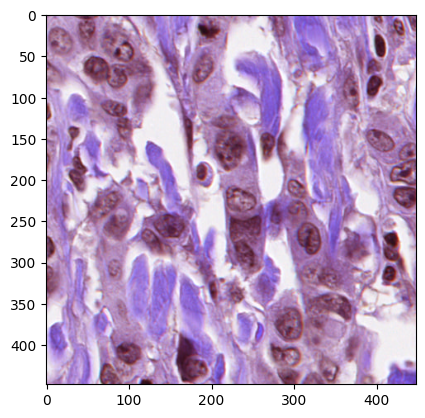

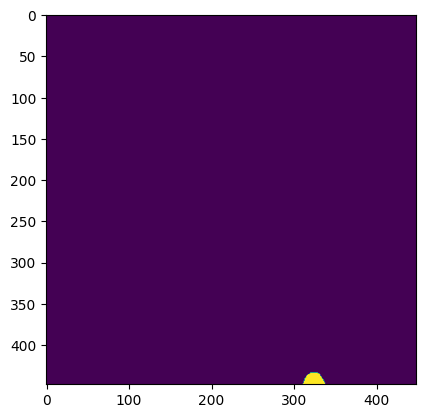

In [6]:
for x, y in train_data:
    plt.imshow(np.array(x)[0,:,:,:].T)
    plt.show()
    plt.imshow(np.array(y)[0,:,:].T)
    plt.show()
    break